## Define system-specific paths, variables, data to be used, etc.

In [3]:

data_path  =    '/Users/lukeaparsons/Documents/Manuscripts/CMIP6_HeatPatterns/data/'

gwfs = (0, 1, 2, 3, 4) #these are all global warming factors for loading data, looking at various warming thresholds

LaborTypes = ['light','medium','heavy']

n = 2 #set labor type: 2 is heavy

variables = ['12hrworkday',
             'hottest_hour',
             'coolest_hour',
             '2ndcoolest_hour',
             '3rdcoolest_hour']

strings_warmingfactors = ['2001_2020_mean',
                         'globalwarming_1C',
                         'globalwarming_2C',
                         'globalwarming_3C',
                         'globalwarming_4C']

#variable names follow forms such as:
# annual_hours_lost_12hrworkday_2001_2020_mean
# annual_hours_lost_12hrworkday_globalwarming_1C
# annual_hours_lost_12hrworkday_globalwarming_2C
# annual_hours_lost_12hrworkday_globalwarming_3C
# annual_hours_lost_12hrworkday_globalwarming_4C

## Import modules for analysis/plotting


In [2]:

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm
import matplotlib.colors as colors

## loop through loading the netcdf files


In [5]:
nc_labor = xr.open_dataset(data_path + 'heavylaborlost_global_populationweighted_annual_hours_lost_mean_present_warming_1_2_3_4_C_grid_05x05.nc')
nc_prod = xr.open_dataset(data_path + 'heavylaborlost_global_populationweighted_annual_productivity2017PPP_lost_mean_present_warming_1_2_3_4_C_grid_05x05.nc')


## calculate global sums of labor and productivity (2017 PPP$) losses

In [13]:
 
for variable in variables:
    print('Calculating global sums for:',variable)

    vars()['Global_Land_ILOHeavyLabor_'+str(variable)] = np.empty(len(gwfs))
    vars()['Global_Land_WB_GDP_ILOHeavyLabor_'+str(variable)] = np.empty(len(gwfs))

    for gi,gwf in enumerate(strings_warmingfactors):
        #print('Calculating global sums for:',variable,' for gwf:',gwf)
        hourslost = nc_labor['annual_hours_lost_'+str(variable)+'_'+str(gwf)]
        vars()['Global_Land_ILOHeavyLabor_'+str(variable)][gi] = hourslost.sum(dim=('lat','lon')).values
        prodlost = nc_prod['annual_productivity_lost_'+str(variable)+'_'+str(gwf)]
        vars()['Global_Land_WB_GDP_ILOHeavyLabor_'+str(variable)][gi] = prodlost.sum(dim=('lat','lon')).values

Calculating global sums for: 12hrworkday
Calculating global sums for: hottest_hour
Calculating global sums for: coolest_hour
Calculating global sums for: 2ndcoolest_hour
Calculating global sums for: 3rdcoolest_hour


## plot Heavy labor lost in ILO ag and construction sectors

For Global DeltaT of 0 , percent of hottest hour recovered via moving 1 hour to morning is: 79.0
For Global DeltaT of 0 , percent of hottest hour recovered via moving 1 hour to coolest hour is: 83.0
For Global DeltaT of 0 , percent of 12hr Workday recovered via moving 3 hours to morning is: 30.0
For Global DeltaT of 0 , percent of 12hr Workday still lost via moving 3 hours to morning is: 70.0
For Global DeltaT of 1 , percent of hottest hour recovered via moving 1 hour to morning is: 76.0
For Global DeltaT of 1 , percent of hottest hour recovered via moving 1 hour to coolest hour is: 80.0
For Global DeltaT of 1 , percent of 12hr Workday recovered via moving 3 hours to morning is: 28.0
For Global DeltaT of 1 , percent of 12hr Workday still lost via moving 3 hours to morning is: 72.0
For Global DeltaT of 2 , percent of hottest hour recovered via moving 1 hour to morning is: 73.0
For Global DeltaT of 2 , percent of hottest hour recovered via moving 1 hour to coolest hour is: 77.0
For Globa

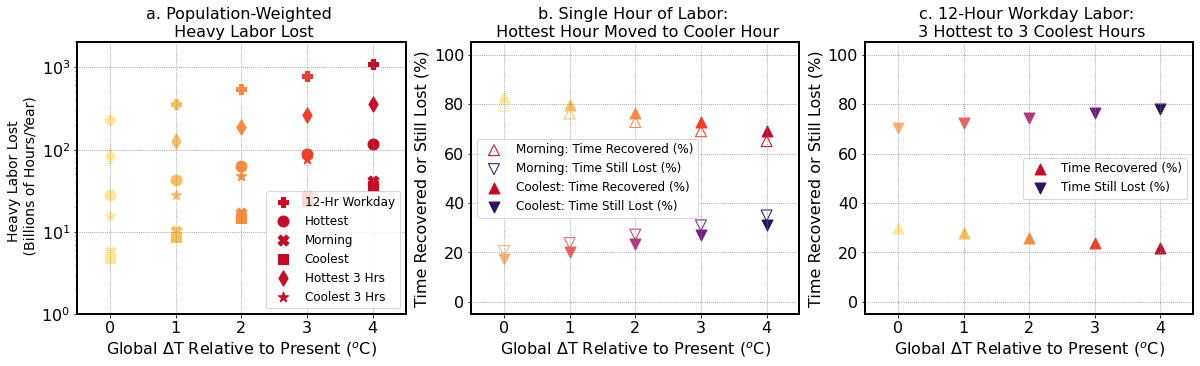

In [15]:
#ILO Heavy Labor Lost

colors_lost = plt.cm.YlOrRd(np.linspace(0,1,2+len(gwfs)))
colorssaved = plt.cm.YlOrRd(np.linspace(0,1,2+len(gwfs)))
colorslost = plt.cm.magma_r(np.linspace(0,1,2+len(gwfs)))

fig = plt.figure(figsize=(20,5), linewidth=3)
msize=120

variables = ['12hrworkday',
             'hottest_hour',
             'coolest_hour',
             '2ndcoolest_hour',
             '3rdcoolest_hour']

pp = 0
for gwf in gwfs:
        
    ax = plt.subplot(1,3,1)
    if gwf == 4:
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_12hrworkday[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="P",label=str('12-Hr Workday'))
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_hottest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,label=str('Hottest'))
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="X",label=str('Morning'))
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_coolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="s",label=str('Coolest'))
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_hottest_hour[pp]*3/1e9,color=colors_lost[pp+1,:],s=msize,marker="d",label=str('Hottest 3 Hrs'))
        plt.scatter(gwfs[pp],(Global_Land_ILOHeavyLabor_coolest_hour[pp]+
                              Global_Land_ILOHeavyLabor_2ndcoolest_hour[pp]+
                              Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp])/1e9,
                             color=colors_lost[pp+1,:],s=msize,marker="*",label=str('Coolest 3 Hrs'))

        
    else:
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_12hrworkday[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="P")
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_coolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="s")
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="X")
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_hottest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize)
        plt.scatter(gwfs[pp],Global_Land_ILOHeavyLabor_hottest_hour[pp]*3/1e9,color=colors_lost[pp+1,:],s=msize,marker="d")
        plt.scatter(gwfs[pp],(Global_Land_ILOHeavyLabor_coolest_hour[pp]+
                      Global_Land_ILOHeavyLabor_2ndcoolest_hour[pp]+
                      Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp])/1e9,
                     color=colors_lost[pp+1,:],s=msize,marker="*")     
    plt.grid('True',color='gray', linestyle=':')
    plt.xlabel('Global $\Delta$T Relative to Present ($^o$C)',fontsize=16)
    plt.xlim(-.5, 4.5)
    plt.ylim(1e0, 2e3)
    plt.ylabel('Heavy Labor Lost \n (Billions of Hours/Year)',fontsize=14)
    if gwf == 4:
        plt.legend(fontsize=12)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yscale('log')
    plt.title('a. Population-Weighted \n Heavy Labor Lost',fontsize=16) 
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    
    ax = plt.subplot(1,3,2)
    if gwf == 4:
        plt.scatter(gwfs[pp],(100-(Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:],s=msize, facecolors='none',marker="^",label=str('Morning: Time Recovered (%)'))
        plt.scatter(gwfs[pp],((Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:],s=msize, facecolors='none',marker="v",label=str('Morning: Time Still Lost (%)'))
    else:
        plt.scatter(gwfs[pp],(100-(Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:], facecolors='none',s=msize,marker="^")
        plt.scatter(gwfs[pp],((Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:], facecolors='none',s=msize,marker="v")
    if gwf == 4:
        plt.scatter(gwfs[pp],(100-(Global_Land_ILOHeavyLabor_coolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:],s=msize,marker="^",label=str('Coolest: Time Recovered (%)'))
        plt.scatter(gwfs[pp],((Global_Land_ILOHeavyLabor_coolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:],s=msize,marker="v",label=str('Coolest: Time Still Lost (%)'))
    else:
        plt.scatter(gwfs[pp],(100-(Global_Land_ILOHeavyLabor_coolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:],s=msize,marker="^")
        plt.scatter(gwfs[pp],((Global_Land_ILOHeavyLabor_coolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:],s=msize,marker="v")
    
    print('For Global DeltaT of',gwf,', percent of hottest hour recovered via moving 1 hour to morning is:',np.round(100-(Global_Land_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)))
    print('For Global DeltaT of',gwf,', percent of hottest hour recovered via moving 1 hour to coolest hour is:',np.round(100-(Global_Land_ILOHeavyLabor_coolest_hour[pp]/Global_Land_ILOHeavyLabor_hottest_hour[pp]*100)))
    
    plt.grid('True',color='gray', linestyle=':')
    plt.xlabel('Global $\Delta$T Relative to Present ($^o$C)',fontsize=16)
    plt.xlim(-.5, 4.5)
    plt.ylim(-5, 105)
    plt.ylabel('Time Recovered or Still Lost (%)',fontsize=16)
    if gwf == 4:
        plt.legend(fontsize=12,loc='center left')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.title('b. Single Hour of Labor: \n Hottest Hour Moved to Cooler Hour',fontsize=16) 
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    #plt.legend(fontsize=14)
    
    ax = plt.subplot(1,3,3)
    Coolest3Global = (Global_Land_ILOHeavyLabor_coolest_hour[gwf]+
                              Global_Land_ILOHeavyLabor_2ndcoolest_hour[gwf]+
                              Global_Land_ILOHeavyLabor_3rdcoolest_hour[gwf])
    Hottest3Global = Global_Land_ILOHeavyLabor_hottest_hour[gwf] * 3
    Workday12hrGlobal = Global_Land_ILOHeavyLabor_12hrworkday[gwf]
    Workday12hrGlobal_NoHottest3 = Workday12hrGlobal - Hottest3Global
    Workday12hrGlobal_NoHottest3_MovedToCoolest3 = Workday12hrGlobal_NoHottest3 + Coolest3Global
    if gwf == 4:
        plt.scatter(gwfs[gwf],100-100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorssaved[gwf+1,:],s=msize,marker="^",label=str('Time Recovered (%)'))
        plt.scatter(gwfs[gwf],100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorslost[gwf+1,:],s=msize,marker="v",label=str('Time Still Lost (%)'))
    else:
        plt.scatter(gwfs[gwf],100-100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorssaved[gwf+1,:],s=msize,marker="^")
        plt.scatter(gwfs[gwf],100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorslost[gwf+1,:],s=msize,marker="v")
    print('For Global DeltaT of',gwf,', percent of 12hr Workday recovered via moving 3 hours to morning is:',np.round(100-100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal)))
    print('For Global DeltaT of',gwf,', percent of 12hr Workday still lost via moving 3 hours to morning is:',np.round(100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal)))    
    plt.grid('True',color='gray', linestyle=':')
    plt.xlabel('Global $\Delta$T Relative to Present ($^o$C)',fontsize=16)
    plt.xlim(-.5, 4.5)
    plt.ylim(-5, 105)
    plt.ylabel('Time Recovered or Still Lost (%)',fontsize=16)
    if gwf == 4:
        plt.legend(fontsize=12,loc='center right')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.title('c. 12-Hour Workday Labor: \n 3 Hottest to 3 Coolest Hours',fontsize=16) 
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        
    
    pp = pp + 1    
    
#plt.savefig(FIGUREPATH +'Figure4abc_PopulationWeighted.eps', format='eps')


## ILO heavy labor lost * World Bank sector specific GDP contributions to overall GDP

For Global DeltaT of 0 , percent of 12hr Workday recovered via moving 3 hours to morning is: 30.0
For Global DeltaT of 0 , percent of 12hr Workday still lost via moving 3 hours to morning is: 70.0
For Global DeltaT of 1 , percent of 12hr Workday recovered via moving 3 hours to morning is: 28.0
For Global DeltaT of 1 , percent of 12hr Workday still lost via moving 3 hours to morning is: 72.0
For Global DeltaT of 2 , percent of 12hr Workday recovered via moving 3 hours to morning is: 26.0
For Global DeltaT of 2 , percent of 12hr Workday still lost via moving 3 hours to morning is: 74.0
For Global DeltaT of 3 , percent of 12hr Workday recovered via moving 3 hours to morning is: 24.0
For Global DeltaT of 3 , percent of 12hr Workday still lost via moving 3 hours to morning is: 76.0
For Global DeltaT of 4 , percent of 12hr Workday recovered via moving 3 hours to morning is: 22.0
For Global DeltaT of 4 , percent of 12hr Workday still lost via moving 3 hours to morning is: 78.0


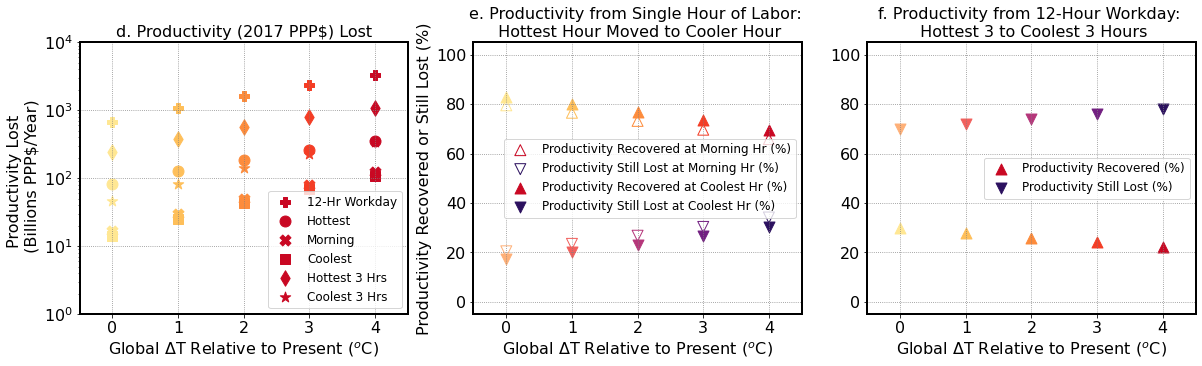

In [17]:

fig = plt.figure(figsize=(20,5), linewidth=3)

pp = 0
for gwf in gwfs:
    ax = plt.subplot(1,3,1)
    if gwf == 4:
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_12hrworkday[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="P",label=str('12-Hr Workday'))
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,label=str('Hottest'))
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="X",label=str('Morning'))
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="s",label=str('Coolest'))
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*3/1e9,color=colors_lost[pp+1,:],s=msize,marker="d",label=str('Hottest 3 Hrs'))
        plt.scatter(gwfs[pp],(Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]+
                              Global_Land_WB_GDP_ILOHeavyLabor_2ndcoolest_hour[pp]+
                              Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp])/1e9,
                             color=colors_lost[pp+1,:],s=msize,marker="*",label=str('Coolest 3 Hrs'))

        
    else:
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_12hrworkday[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="P")
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="s")
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize,marker="X")
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]/1e9,color=colors_lost[pp+1,:],s=msize)
        plt.scatter(gwfs[pp],Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*3/1e9,color=colors_lost[pp+1,:],s=msize,marker="d")
        plt.scatter(gwfs[pp],(Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]+
                      Global_Land_WB_GDP_ILOHeavyLabor_2ndcoolest_hour[pp]+
                      Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp])/1e9,
                     color=colors_lost[pp+1,:],s=msize,marker="*")       
    plt.grid('True',color='gray', linestyle=':')
    plt.xlabel('Global $\Delta$T Relative to Present ($^o$C)',fontsize=16)
    plt.xlim(-0.5, 4.5)
    plt.ylim(1e0, 1e4)
    plt.ylabel('Productivity Lost \n (Billions PPP$/Year)',fontsize=16)
    if gwf == 4:
        plt.legend(fontsize=12,loc='lower right')
    plt.yscale('log')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.title('d. Productivity (2017 PPP$) Lost',fontsize=16)   
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        
    ax = plt.subplot(1,3,2)
    if gwf == 4:
        plt.scatter(gwfs[pp],(100-(Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:], facecolors='none',s=msize,marker="^",label=str('Productivity Recovered at Morning Hr (%)'))
        plt.scatter(gwfs[pp],((Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:], facecolors='none',s=msize,marker="v",label=str('Productivity Still Lost at Morning Hr (%)'))
    else:
        plt.scatter(gwfs[pp],(100-(Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:], facecolors='none',s=msize,marker="^")
        plt.scatter(gwfs[pp],((Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:], facecolors='none',s=msize,marker="v")
    if gwf == 4:
        plt.scatter(gwfs[pp],(100-(Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:],s=msize,marker="^",label=str('Productivity Recovered at Coolest Hr (%)'))
        plt.scatter(gwfs[pp],((Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:],s=msize,marker="v",label=str('Productivity Still Lost at Coolest Hr (%)'))
    else:
        plt.scatter(gwfs[pp],(100-(Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorssaved[pp+1,:],s=msize,marker="^")
        plt.scatter(gwfs[pp],((Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100)),color=colorslost[pp+1,:],s=msize,marker="v")
    #plt.scatter(gwfs[pp],100-(Global_Land_3rdcoolest_hour[pp]/Global_Land_hottest_hour[pp]*100),color=colorssaved[pp,:],s=msize,marker="v",label=str('Off-Peak gwf: ' + str(gwf)))#plt.grid('True')
    plt.grid('True',color='gray', linestyle=':')
    plt.xlabel('Global $\Delta$T Relative to Present ($^o$C)',fontsize=16)
    plt.xlim(-0.5, 4.5)
    plt.ylim(-5, 105)
    plt.ylabel('Productivity Recovered or Still Lost (%)',fontsize=16)
    if gwf == 4:
        plt.legend(fontsize=12)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.title('e. Productivity from Single Hour of Labor: \n Hottest Hour Moved to Cooler Hour',fontsize=16) 
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    
    ax = plt.subplot(1,3,3)
    Coolest3Global = (Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[gwf]+
                              Global_Land_WB_GDP_ILOHeavyLabor_2ndcoolest_hour[gwf]+
                              Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[gwf])
    Hottest3Global = Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[gwf] * 3
    Workday12hrGlobal = Global_Land_WB_GDP_ILOHeavyLabor_12hrworkday[gwf]
    Workday12hrGlobal_NoHottest3 = Workday12hrGlobal - Hottest3Global
    Workday12hrGlobal_NoHottest3_MovedToCoolest3 = Workday12hrGlobal_NoHottest3 + Coolest3Global
    if gwf == 4:
        plt.scatter(gwfs[gwf],100-100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorssaved[gwf+1,:],s=msize,marker="^",label=str('Productivity Recovered (%)'))
        plt.scatter(gwfs[gwf],100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorslost[gwf+1,:],s=msize,marker="v",label=str('Productivity Still Lost (%)'))
    else:
        plt.scatter(gwfs[gwf],100-100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorssaved[gwf+1,:],s=msize,marker="^")
        plt.scatter(gwfs[gwf],100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal),color=colorslost[gwf+1,:],s=msize,marker="v")
    print('For Global DeltaT of',gwf,', percent of 12hr Workday recovered via moving 3 hours to morning is:',np.round(100-100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal)))
    print('For Global DeltaT of',gwf,', percent of 12hr Workday still lost via moving 3 hours to morning is:',np.round(100*(Workday12hrGlobal_NoHottest3_MovedToCoolest3/Workday12hrGlobal)))    
    plt.grid('True',color='gray', linestyle=':')
    plt.xlabel('Global $\Delta$T Relative to Present ($^o$C)',fontsize=16)
    plt.xlim(-.5, 4.5)
    plt.ylim(-5, 105)
    if gwf == 4:
        plt.legend(fontsize=12,loc='center right')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.title('f. Productivity from 12-Hour Workday: \n Hottest 3 to Coolest 3 Hours',fontsize=16) 
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)   
    
    pp = pp + 1
    
    
#fig.savefig(FIGUREPATH + 'Figure4def_PopulationWeighted',dpi=200,bbox_inches='tight')

#plt.savefig(FIGUREPATH +'Figure4def_PopulationWeighted.eps', format='eps')

# now list the global productivity lost and percent regained per degree


In [19]:

Recovered_Percent_Morning = np.empty([len(gwfs)])
Recovered_Percent_Sunrise = np.empty([len(gwfs)])

gwfs_relative0 = np.arange(0,5,1)
gwfs_relative0_deltas = np.arange(0,5,1)

pp = 0
for gwf in gwfs:
    
    Recovered_Percent_Morning[pp] = (100-(Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100))
    Recovered_Percent_Sunrise[pp] = (100-(Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[pp]/Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[pp]*100))
    pp = pp + 1

Recovered_Percent_Morning_relative0 = Recovered_Percent_Morning - Recovered_Percent_Morning[0]
Recovered_Percent_Sunrise_relative0 = Recovered_Percent_Sunrise - Recovered_Percent_Sunrise[0]

print('For morning, hours recovered are:')
print(np.round(Recovered_Percent_Morning, decimals=2))
print(np.round(Recovered_Percent_Morning_relative0, decimals=2))
print(np.round(Recovered_Percent_Morning_relative0/gwfs_relative0_deltas, decimals=2))
print('')
print('For sunrise, hours recovered are:')
print(np.round(Recovered_Percent_Sunrise, decimals=2))
print(np.round(Recovered_Percent_Sunrise_relative0, decimals=2))
print(np.round(Recovered_Percent_Sunrise_relative0/gwfs_relative0_deltas, decimals=2))

For morning, hours recovered are:
[79.55 76.54 73.24 69.67 65.86]
[  0.    -3.01  -6.3   -9.87 -13.68]
[  nan -3.01 -3.15 -3.29 -3.42]

For sunrise, hours recovered are:
[82.78 79.96 76.84 73.4  69.69]
[  0.    -2.82  -5.94  -9.38 -13.09]
[  nan -2.82 -2.97 -3.13 -3.27]


## print out the productivity lost (217 PPP$) in various parts of the day for gwf 0:


In [21]:
gwf = 0

print('for gwf ',gwf,'GDP Productivity Losses globally for 12hr workday are: ',Global_Land_WB_GDP_ILOHeavyLabor_12hrworkday[gwf]/1e9,' billion (2017PPP$)')
print('for gwf ',gwf,'GDP Productivity Losses globally for coolest hour are: ',Global_Land_WB_GDP_ILOHeavyLabor_coolest_hour[gwf]/1e9,' billion (2017PPP$)')
print('for gwf ',gwf,'GDP Productivity Losses globally for 3rd coolest hour are: ',Global_Land_WB_GDP_ILOHeavyLabor_3rdcoolest_hour[gwf]/1e9,' bbillion (2017PPP$)')
print('for gwf ',gwf,'GDP Productivity Losses globally for hottest hour are: ',Global_Land_WB_GDP_ILOHeavyLabor_hottest_hour[gwf]/1e9,' billion (2017PPP$)')


for gwf  0 GDP Productivity Losses globally for 12hr workday are:  669.9891623534764  billion (2017PPP$)
for gwf  0 GDP Productivity Losses globally for coolest hour are:  14.153785255904308  billion (2017PPP$)
for gwf  0 GDP Productivity Losses globally for 3rd coolest hour are:  16.812662743801614  bbillion (2017PPP$)
for gwf  0 GDP Productivity Losses globally for hottest hour are:  82.19468901061092  billion (2017PPP$)
